# __begin__

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline


In [2]:
import torch
import torchaudio as ta
import torchaudio.functional as taf
import torchaudio.transforms as tat

print(torch.__version__)
print(ta.__version__)

import matplotlib
import matplotlib.pyplot as plt
from IPython.display import Audio, display

import pandas as pd
import os
import pprint

from typing import *
import itertools
from collections import Counter

import numpy as np
import math

from lark.data import *

1.8.1
0.8.0a0+e4e171a


In [3]:
torch.cuda.set_device(1)
torch.cuda.current_device()

1

In [34]:
fname = "data/birdclef-2021/train_short_audio/yebela1/XC389231.ogg"

In [35]:
info = ta.info(fname)

In [36]:
info.sample_rate

32000

In [37]:
info.num_channels

1

In [38]:
info.encoding

'VORBIS'

In [39]:
sr = 32000
n_fft=512
window_length=512
n_mels=64
hop_length=312
f_min=150
f_max=15000

In [40]:
melspec = tat.MelSpectrogram(
            sample_rate=sr,
            n_fft=n_fft,
            win_length=window_length,
            hop_length=hop_length,
            f_min=f_min,
            f_max=f_max,
            pad=0,
            n_mels=n_mels,
            power=2.0,
            normalized=True, )

In [41]:
p2db = tat.AmplitudeToDB(stype='power', top_db=80)

In [42]:
t, sr = ta.load(fname)

In [43]:
def print_metadata(metadata, src=None):
  if src:
    print("-" * 10)
    print("Source:", src)
    print("-" * 10)
  print(" - sample_rate:", metadata.sample_rate)
  print(" - num_channels:", metadata.num_channels)
  print(" - num_frames:", metadata.num_frames)
  print(" - bits_per_sample:", metadata.bits_per_sample)
  print(" - encoding:", metadata.encoding)
  print()

In [44]:
def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].specgram(waveform[c], Fs=sample_rate, cmap='viridis')
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
  figure.suptitle(title)
  plt.show(block=False)

In [45]:
def plot_mel_fbank(fbank, title=None):
  fig, axs = plt.subplots(1, 1)
  axs.set_title(title or 'Filter bank')
  axs.imshow(fbank, aspect='auto')
  axs.set_ylabel('frequency bin')
  axs.set_xlabel('mel bin')
  plt.show(block=False)


In [46]:
def play_audio(waveform, sample_rate, autoplay=False):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  if num_channels == 1:
    display(Audio(waveform[0], rate=sample_rate, autoplay=autoplay))
  elif num_channels == 2:
    display(Audio((waveform[0], waveform[1]), rate=sample_rate))
  else:
    raise ValueError("Waveform with more than 2 channels are not supported.")

In [47]:
def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].plot(time_axis, waveform[c], linewidth=1)
    axes[c].grid(True)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
    if ylim:
      axes[c].set_ylim(ylim)
  figure.suptitle(title)
  plt.show(block=False)

In [48]:
def plot_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
  fig, axs = plt.subplots(1, 1)
  axs.set_title(title or 'Spectrogram (db)')
  axs.set_ylabel(ylabel)
  axs.set_xlabel('frame')
  # im = axs.imshow(librosa.power_to_db(spec), origin='lower', aspect=aspect)
  im = axs.imshow(spec.permute(1, 2, 0), origin='lower', aspect=aspect)
  if xmax:
    axs.set_xlim((0, xmax))
  fig.colorbar(im, ax=axs)
  plt.show(block=False)

In [49]:
def plot_pitch(waveform, sample_rate, pitch):
  figure, axis = plt.subplots(1, 1)
  axis.set_title("Pitch Feature")
  axis.grid(True)

  end_time = waveform.shape[1] / sample_rate
  time_axis = torch.linspace(0, end_time,  waveform.shape[1])
  axis.plot(time_axis, waveform[0], linewidth=1, color='gray', alpha=0.3)

  axis2 = axis.twinx()
  time_axis = torch.linspace(0, end_time, pitch.shape[1])
  ln2 = axis2.plot(
      time_axis, pitch[0], linewidth=2, label='Pitch', color='green')

  axis2.legend(loc=0)
  plt.show(block=False)

In [50]:
df_train_meta = pd.read_csv("data/birdclef-2021/train_metadata.csv")
df_train_meta

primary_label                           secondary_labels  \
0            acafly                                 ['amegfi']   
1            acafly                                         []   
2            acafly                                         []   
3            acafly                                ['whwbec1']   
4            acafly                                ['whwbec1']   
...             ...                                        ...   
62869        yetvir                                         []   
62870        yetvir                                         []   
62871        yetvir  ['amered', 'eawpew', 'norcar', 'reevir1']   
62872        yetvir                                         []   
62873        yetvir                       ['gamqua', 'whwdov']   

                                                    type  latitude  longitude  \
0                   ['begging call', 'call', 'juvenile']   35.3860   -84.1250   
1                                               ['call']    9.1334   -79.6501   
2                                               ['call']    5.7813   -75.7452   
3                                               ['call']    4.6717   -75.6283   
4                                               ['call']    4.6717   -75.6283   
...                                                  ...       ...        ...   
62869                          ['adult', 'male', 'song']   30.2150   -97.6505   
62870  ['life stage uncertain', 'sex uncertain', 'song']   42.3005   -72.5877   
62871                          ['adult', 'male', 'song']   42.3005   -72.5877   
62872                                      ['uncertain']   32.2357   -99.8811   
62873                          ['adult', 'male', 'song']   31.9060  -109.1543   

           scientific_name            common_name                      author  \
0      Empidonax virescens     Acadian Flycatcher                 Mike Nelson   
1      Empidonax virescens     Acadian Flycatcher           Allen T. Chartier   
2      Empidonax virescens     Acadian Flycatcher     Sergio Chaparro-Herrera   
3      Empidonax virescens     Acadian Flycatcher  Oscar Humberto Marin-Gomez   
4      Empidonax virescens     Acadian Flycatcher  Oscar Humberto Marin-Gomez   
...                    ...                    ...                         ...   
62869     Vireo flavifrons  Yellow-throated Vireo                Caleb Helsel   
62870     Vireo flavifrons  Yellow-throated Vireo       Christopher McPherson   
62871     Vireo flavifrons  Yellow-throated Vireo       Christopher McPherson   
62872     Vireo flavifrons  Yellow-throated Vireo                 Brad Banner   
62873     Vireo flavifrons  Yellow-throated Vireo          Richard E. Webster   

             date      filename  \
0      2012-08-12  XC109605.ogg   
1      2000-12-26   XC11209.ogg   
2      2012-01-10  XC127032.ogg   
3      2009-06-19  XC129974.ogg   
4      2009-06-19  XC129981.ogg   
...           ...           ...   
62869  2020-07-10  XC591680.ogg   
62870  2019-05-31  XC600085.ogg   
62871  2020-06-02  XC602701.ogg   
62872  2019-04-27  XC614733.ogg   
62873  2020-05-26  XC615888.ogg   

                                                 license  rating   time  \
0      Creative Commons Attribution-NonCommercial-Sha...     2.5  09:30   
1      Creative Commons Attribution-NonCommercial-Sha...     3.0      ?   
2      Creative Commons Attribution-NonCommercial-Sha...     3.0  15:20   
3      Creative Commons Attribution-NonCommercial-Sha...     3.5  07:50   
4      Creative Commons Attribution-NonCommercial-Sha...     3.5  07:50   
...                                                  ...     ...    ...   
62869  Creative Commons Attribution-NonCommercial-Sha...     1.0  08:30   
62870  Creative Commons Attribution-NonCommercial-Sha...     5.0  09:30   
62871  Creative Commons Attribution-NonCommercial-Sha...     4.5  08:30   
62872  Creative Commons Attribution-NonCommercial-Sha...     4.0  17:30   
62873  Creative Commo

In [51]:
def show_waveform(fname, show_pitch=False):
    
    pp = pprint.PrettyPrinter(indent=2)
    
    info = ta.info(fname)
    print_metadata(info, fname)
    
    bn = os.path.basename(fname).replace('wav', 'ogg')
    entry = df_train_meta[df_train_meta.filename == bn].to_dict(orient='records')
    pp.pprint(entry)
    
    wf, sr = ta.load(fname)
    play_audio(wf, sr)
    # plot_specgram(wf, sr)
    plot_spectrogram(p2db(melspec(wf)))
    if show_pitch:
        pitch = taf.detect_pitch_frequency(wf, sr)
        plot_pitch(wf, sr, pitch)
    

----------
Source: data/birdclef-2021/train_short_audio/yebela1/XC389231.ogg
----------
 - sample_rate: 32000
 - num_channels: 1
 - num_frames: 257080
 - bits_per_sample: 0
 - encoding: VORBIS

[ { 'author': 'Lari Boesing',
    'common_name': 'Yellow-bellied Elaenia',
    'date': '2014-09-17',
    'filename': 'XC389231.ogg',
    'latitude': -23.2261,
    'license': 'Creative Commons Attribution-NonCommercial-ShareAlike 4.0',
    'longitude': -46.347,
    'primary_label': 'yebela1',
    'rating': 4.0,
    'scientific_name': 'Elaenia flavogaster',
    'secondary_labels': '[]',
    'time': '09:30',
    'type': "['song']",
    'url': 'https://www.xeno-canto.org/389231'}]


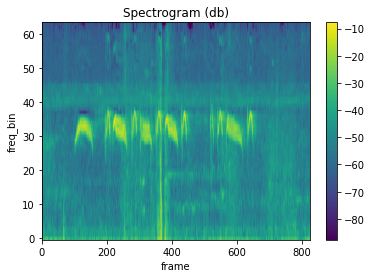

In [52]:
show_waveform(fname)

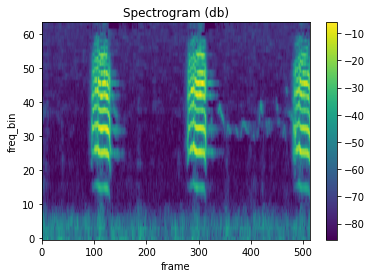

In [34]:
sig = read_random_sig(f"data/birdclef-2021/train_short_audio.wav/brnjay/", 160000)
play_audio(sig, sr)
plot_spectrogram(p2db(melspec(sig)))

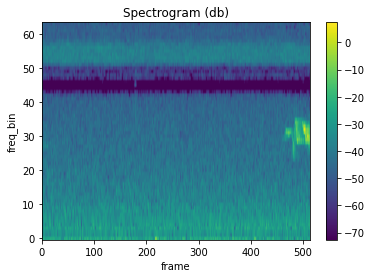

In [35]:
sig2 = read_random_sig(f"data/birdclef-2021/train_short_audio.wav/rubpep1/", 160000)
play_audio(sig2, sr)
plot_spectrogram(p2db(melspec(sig2)))

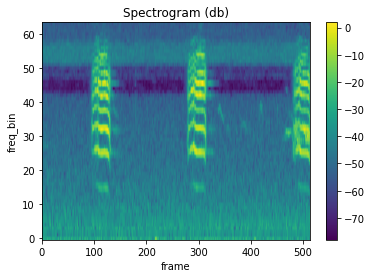

In [36]:
sig_mixed = merge_sigs(sig, sig2, 0)
play_audio(sig_mixed, sr)
plot_spectrogram(p2db(melspec(sig_mixed)))

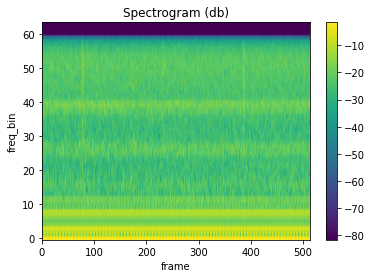

In [37]:
noise_dir = 'data/noise/BirdVox-DCASE-20k/wav-32k'
# noise_dir = '/home/koen/data/kaggle-birdsong-recognition-2020/noise/ff1010bird_wav/wav'
# noise_dir = 'data/noise/warblrb10k_public_wav/wav-32k'
noise = read_random_sig(noise_dir, 160000)
play_audio(noise, sr)
plot_spectrogram(p2db(melspec(noise)))

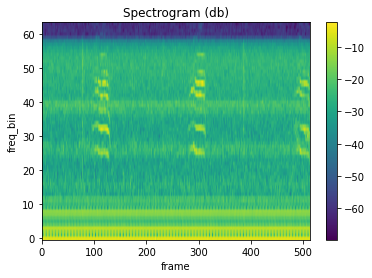

In [38]:
noise_sig = merge_sigs(noise, sig_mixed, 20)
play_audio(noise_sig, sr)
plot_spectrogram(p2db(melspec(noise_sig)))

In [39]:
107520 / 28

3840.0

In [40]:
a = noise_sig.norm(p=2).item()
a

74.71603393554688

In [41]:
b = torch.Tensor([0.0])
b

tensor([0.])

In [42]:
noise_sig

tensor([[-0.0715, -0.0820, -0.0673,  ..., -0.3235, -0.3121, -0.3071]])

In [43]:
sig

tensor([[ 0.0003,  0.0003,  0.0005,  ..., -0.0035, -0.0046, -0.0004]])

In [46]:
# show_waveform("data/birdclef-2021/train_soundscapes/2782_SSW_20170701.ogg")

In [47]:
# show_waveform("data/birdclef-2021/train_soundscapes.wav/2782_SSW_20170701.ogg.wav")

# metadata

In [110]:
cfg = Config(sites=['SSW'],
             use_noise=True
            )

In [111]:
df_meta = pd.read_csv(f"data/birdclef-2021/train_metadata.csv")
df_meta['secondary_labels'] = df_meta['secondary_labels'].str.replace("[\[\]',]", '', regex=True).str.split()
df_meta['filename'] = df_meta['filename'].str.replace(".ogg", '.wav', regex=False)

In [112]:
df_meta['filename'] = df_meta.apply(lambda r: f"data/birdclef-2021/train_short_audio.wav/{r['primary_label']}/{r['filename']}", axis=1)

In [113]:
df_meta['file_exists'] = df_meta.apply(lambda r: os.path.exists(r['filename']), axis=1)

In [114]:
df_meta[df_meta['file_exists'] == False]

primary_label secondary_labels                                   type  \
16324        cogdov               []  ['aberrant', 'adult', 'male', 'song']   
24512        gockin               []                               ['call']   

       latitude  longitude      scientific_name             common_name  \
16324   11.4947   -69.5128  Columbina passerina      Common Ground Dove   
24512   45.3219  -122.5735      Regulus satrapa  Golden-crowned Kinglet   

                    author        date  \
16324  Francisco contreras  2020-07-15   
24512      Kirill Ignatyev  2014-01-21   

                                                filename  \
16324  data/birdclef-2021/train_short_audio.wav/cogdo...   
24512  data/birdclef-2021/train_short_audio.wav/gocki...   

                                                 license  rating   time  \
16324  Creative Commons Attribution-NonCommercial-Sha...     4.0  10:00   
24512        Creative Commons Attribution-ShareAlike 3.0     4.0  14:32   

                                     url  file_exists  
16324  https://www.xeno-canto.org/579430        False  
24512  https://www.xeno-canto.org/165209        False

In [115]:
df_meta = df_meta[df_meta['file_exists'] == True]

In [116]:
df_meta.apply(lambda r: ta.info(r['filename']).num_frames, axis=1)

0        2037632
1         533312
2        1508480
3         450304
4        1301248
          ...   
62869    1424704
62870    2510784
62871    3260352
62872     525888
62873    2468416
Length: 62872, dtype: int64

In [138]:
tdl = TrainDataset(cfg).loader

In [139]:
tdi = iter(tdl)

In [140]:
x, y = next(tdi)

In [141]:
import lark 
ms2s = lark.ops.MixedSig2Spec(cfg, forward_as_image=True)

In [142]:
tx = ms2s(x.cuda()).cpu()

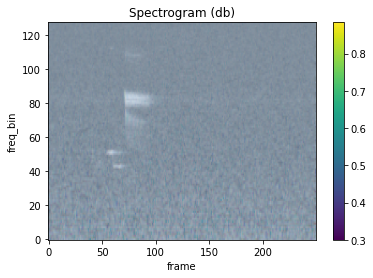

In [143]:
plot_spectrogram(tx[23])

## train soundscapes

In [39]:
df_ss = pd.read_csv("data/birdclef-2021/train_soundscape_labels.csv")
df_ss

row_id site  audio_id  seconds   birds
0        7019_COR_5  COR      7019        5  nocall
1       7019_COR_10  COR      7019       10  nocall
2       7019_COR_15  COR      7019       15  nocall
3       7019_COR_20  COR      7019       20  nocall
4       7019_COR_25  COR      7019       25  nocall
...             ...  ...       ...      ...     ...
2395  54955_SSW_580  SSW     54955      580  nocall
2396  54955_SSW_585  SSW     54955      585  grycat
2397  54955_SSW_590  SSW     54955      590  grycat
2398  54955_SSW_595  SSW     54955      595  nocall
2399  54955_SSW_600  SSW     54955      600  nocall

[2400 rows x 5 columns]

In [54]:
df_ssx = df_ss[df_ss['birds'] != 'nocall'].reset_index(drop=True)
df_ssx['birds'] = df_ssx['birds'].str.split(' ')
df_ssx['n_birds'] = df_ssx['birds'].map(len)
df_cnts = df_ssx[['n_birds', 'row_id']].groupby('n_birds').count()

df_cnts /= df_cnts.sum()
df_cnts.values

array([[0.71986223],
       [0.21010333],
       [0.06314581],
       [0.00574053],
       [0.00114811]])

In [23]:
ss_birds = dict(Counter(itertools.chain(*df_ss['birds'].str.split(' '))))
ss_birds

{'nocall': 1529,
 'rubwre1': 18,
 'obnthr1': 18,
 'brnjay': 7,
 'sthwoo1': 1,
 'rucwar': 179,
 'grekis': 12,
 'runwre1': 19,
 'rtlhum': 1,
 'hofwoo1': 13,
 'clcrob': 4,
 'yehcar1': 2,
 'melbla1': 2,
 'crfpar': 18,
 'whcpar': 6,
 'bobfly1': 90,
 'grhcha1': 2,
 'plawre1': 12,
 'orcpar': 4,
 'orfpar': 1,
 'bucmot2': 4,
 'bkcchi': 67,
 'grycat': 67,
 'reevir1': 154,
 'eawpew': 78,
 'chswar': 16,
 'blujay': 12,
 'swaspa': 9,
 'dowwoo': 3,
 'rewbla': 78,
 'belkin1': 3,
 'haiwoo': 5,
 'comgra': 3,
 'norwat': 1,
 'amegfi': 6,
 'comyel': 29,
 'sonspa': 90,
 'eastow': 21,
 'norcar': 20,
 'gockin': 19,
 'cangoo': 18,
 'amecro': 1,
 'amerob': 7,
 'yebsap': 8,
 'norfli': 6,
 'woothr': 2,
 'balori': 40,
 'rebwoo': 5,
 'ovenbi1': 2}

<AxesSubplot:>

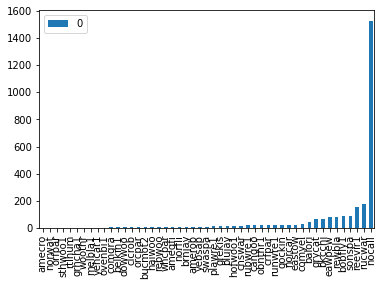

In [24]:
pd.DataFrame.from_dict(ss_birds, orient='index').sort_values(by=0).plot.bar()

<AxesSubplot:>

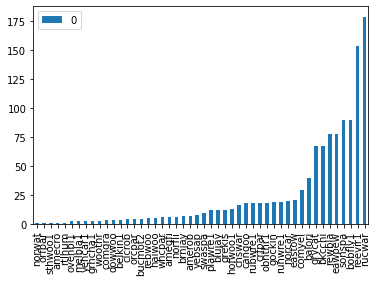

In [25]:
ssx_birds = ss_birds.copy()
del ssx_birds['nocall']
pd.DataFrame.from_dict(ssx_birds, orient='index').sort_values(by=0).plot.bar()

In [26]:
df_ss_birds = pd.DataFrame.from_dict(ss_birds, orient='index').sort_values(by=0).reset_index(drop=False)
df_ss_birds.columns = ['bird', 'count']
df_ss_birds

bird  count
0    amecro      1
1    norwat      1
2    orfpar      1
3   sthwoo1      1
4    rtlhum      1
5   grhcha1      2
6    woothr      2
7   melbla1      2
8   yehcar1      2
9   ovenbi1      2
10   comgra      3
11  belkin1      3
12   dowwoo      3
13   clcrob      4
14   orcpar      4
15  bucmot2      4
16   haiwoo      5
17   rebwoo      5
18   whcpar      6
19   amegfi      6
20   norfli      6
21   brnjay      7
22   amerob      7
23   yebsap      8
24   swaspa      9
25  plawre1     12
26   grekis     12
27   blujay     12
28  hofwoo1     13
29   chswar     16
30  rubwre1     18
31   cangoo     18
32  obnthr1     18
33   crfpar     18
34  runwre1     19
35   gockin     19
36   norcar     20
37   eastow     21
38   comyel     29
39   balori     40
40   grycat     67
41   bkcchi     67
42   eawpew     78
43   rewbla     78
44  bobfly1     90
45   sonspa     90
46  reevir1    154
47   rucwar    179
48   nocall   1529

In [239]:
df_ss_ssw = df_ss[df_ss.site == 'SSW']
df_ss_ssw

row_id site  audio_id  seconds                         birds
1200     2782_SSW_5  SSW      2782        5         bkcchi grycat reevir1
1201    2782_SSW_10  SSW      2782       10         eawpew grycat reevir1
1202    2782_SSW_15  SSW      2782       15  bkcchi eawpew grycat reevir1
1203    2782_SSW_20  SSW      2782       20         eawpew grycat reevir1
1204    2782_SSW_25  SSW      2782       25         eawpew grycat reevir1
...             ...  ...       ...      ...                           ...
2395  54955_SSW_580  SSW     54955      580                        nocall
2396  54955_SSW_585  SSW     54955      585                        grycat
2397  54955_SSW_590  SSW     54955      590                        grycat
2398  54955_SSW_595  SSW     54955      595                        nocall
2399  54955_SSW_600  SSW     54955      600                        nocall

[1200 rows x 5 columns]

In [240]:
ssw_birds = dict(Counter(itertools.chain(*df_ss_ssw['birds'].str.split(' '))))
ssw_birds

{'bkcchi': 67,
 'grycat': 67,
 'reevir1': 154,
 'eawpew': 78,
 'chswar': 16,
 'nocall': 690,
 'blujay': 12,
 'swaspa': 9,
 'dowwoo': 3,
 'rewbla': 78,
 'belkin1': 3,
 'haiwoo': 5,
 'comgra': 3,
 'norwat': 1,
 'amegfi': 6,
 'comyel': 29,
 'sonspa': 90,
 'eastow': 21,
 'norcar': 20,
 'gockin': 19,
 'cangoo': 18,
 'amecro': 1,
 'amerob': 7,
 'yebsap': 8,
 'norfli': 6,
 'woothr': 2,
 'balori': 40,
 'rebwoo': 5,
 'ovenbi1': 2}

# dataloaders

In [92]:
from lark.config import Config
from lark.ops import Sig2Spec
from lark.data import TrainDataset

In [93]:
cfg = Config(sites=None,
    n_mels = 128,
    f_min = 20,
    f_max = 16000,
    n_fft = 2048,
    hop_length = 512,            
            )

In [94]:
cfg

Config(sites=None, data_dir='data/birdclef-2021', checkpoint_dir='checkpoints', bs=32, n_workers=12, train_duration=5, valid_duration=5, seed=231, use_pink_noise=0.5, use_recorded_noise=0.5, use_secondary_labels=False, noise_nsr_dbs=[20, 10, 3], pink_noise_nsr_dbs=[10, 5, 3], noise_dir='data/noise/BirdVox-DCASE-20k/wav-32k', use_overlays=True, max_overlays=5, overlay_weights=[0.71986223, 0.21010333, 0.06314581, 0.00574053, 0.00114811], overlay_snr_dbs=[20, 10, 3], apply_filter=0.6, use_neptune=True, log_batch_metrics=False, sr=32000, n_fft=2048, window_length=512, n_mels=128, hop_length=512, f_min=20, f_max=16000, f1_threshold=0.5, lr=0.001, n_epochs=10, model='Cnn14_DecisionLevelAtt', optimizer='torch.optim.Adam', loss_fn='torch.nn.BCEWithLogitsLoss', scheduler='torch.optim.lr_scheduler.CosineAnnealingLR')

In [95]:
tdl = TrainDataset(cfg).loader

In [96]:
x, y = next(iter(tdl))
y = y.cpu().numpy().astype(int)

In [97]:
x.shape

torch.Size([32, 1, 160000])

In [98]:
ss = Sig2Spec(cfg, forward_as_image=True)

In [99]:
imgs = ss(x)

torch.Size([32, 1, 128, 313])


In [100]:
imgs.shape

torch.Size([32, 3, 128, 313])

In [101]:
i = np.random.randint(cfg.bs)


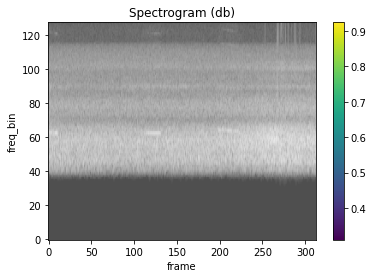

In [102]:
img = imgs[i]
plot_spectrogram(img)

In [103]:
def show_sig(sig, spec, row):
    play_audio(sig, 32000, autoplay=True)
    plot_spectrogram(spec)
    print([f"{cfg.labels[j]}" for j, v in enumerate(row) if v])

In [104]:
from lark import ops
mss = ops.MixedSig2Spec(cfg, forward_as_image=True)
mimgs = mss(x.cuda()).cpu()

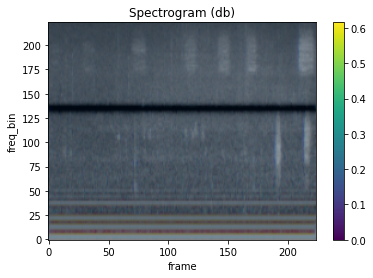

['runwre1']


In [105]:
i = np.random.randint(cfg.bs)
show_sig(x[i], mimgs[i], y[i])

In [146]:
cfg = Config(
    n_workers=12,
    
    n_fft=3200,
    window_length=3200,
    n_mels=128,
    hop_length=800,
    
    use_pink_noise=0,
    use_recorded_noise=0,
    use_overlays=False,
    apply_filter=0,
    sites=None, 
    use_neptune=True, 
    log_batch_metrics=False,
    n_epochs=15, 
    bs=32,
    lr=1e-3, 
    model='resnest50',
    scheduler='torch.optim.lr_scheduler.CosineAnnealingLR'
)

In [132]:
from lark import data
tds = data.TrainDataset(cfg)

torch.Size([1, 1, 128, 313])


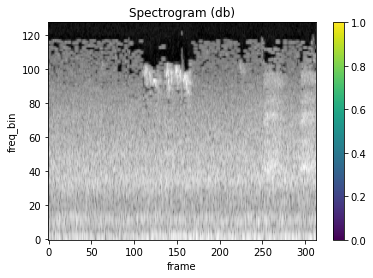

['chbchi']


[('read_sig',
  'data/birdclef-2021/train_short_audio.wav/chbchi/XC164260.wav,2501125')]

In [170]:
x, y, ol = tds.assemble_sig()
ss = ss.cuda()
spec = ss(x.unsqueeze(0).cuda()).cpu()[0]
show_sig(x, spec, y)
ol

In [121]:
x.shape

torch.Size([1, 160000])

# mixed sig2spec

In [79]:
window_lengths = [x*32 for x in [25, 50, 100]]
hop_lengths = [x*32 for x in [10, 25, 50]]

msss = [
    tat.MelSpectrogram(
        sample_rate=32000,
        n_fft=window_lengths[i],
        win_length=window_lengths[i],
        hop_length=hop_lengths[i],
        f_min=cfg.f_min,
        f_max=cfg.f_max,
        pad=0,
        n_mels=128,
        power=2.0,
        normalized=True, 
    ) for i in range(3)
]

In [80]:
hop_lengths

[320, 800, 1600]

In [81]:
window_lengths

[800, 1600, 3200]

In [82]:
msss

[MelSpectrogram(
   (spectrogram): Spectrogram()
   (mel_scale): MelScale()
 ),
 MelSpectrogram(
   (spectrogram): Spectrogram()
   (mel_scale): MelScale()
 ),
 MelSpectrogram(
   (spectrogram): Spectrogram()
   (mel_scale): MelScale()
 )]

In [83]:
tdl = TrainDataset(cfg).loader
tdi = iter(tdl)

In [84]:
x, y = next(tdi)

In [85]:
x.shape

torch.Size([32, 1, 160000])

In [86]:
sig = x[0]
sig_sss = [ ms(sig) for ms in msss]

In [87]:
[s.shape for s in sig_sss]

[torch.Size([1, 128, 501]),
 torch.Size([1, 128, 201]),
 torch.Size([1, 128, 101])]

In [88]:
import torchvision
tf = torchvision.transforms.Resize((128, 250))

In [89]:
def normalize(spec: torch.Tensor) -> torch.Tensor:
    spec -= spec.min()
    if spec.max() != 0:
        spec /= spec.max()
    else:
        spec = torch.clamp(spec, 0, 1)
    return spec

In [90]:
img = torch.cat([tf(ms(sig).log()) for ms in msss])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


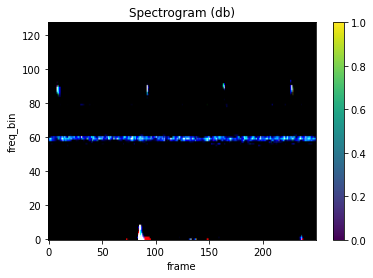

In [91]:
plot_spectrogram(img)

In [211]:
class MixedSig2Spec(torch.nn.Module):
    def __init__(self, cfg: Config):
        super().__init__()
        
        window_lengths = [800, 1600, 3200]
        hop_lengths = [320, 800, 1600]
        
        self.melspecs = [tat.MelSpectrogram(
            sample_rate=32000,
            n_fft=window_lengths[i],
            win_length=window_lengths[i],
            hop_length=hop_lengths[i],
            f_min=cfg.f_min,
            f_max=cfg.f_max,
            pad=0,
            n_mels=128,
            power=2.0,
            normalized=True, 
        ) for i in range(3)]
        
        self.resize = torchvision.transforms.Resize((128, 250))
        
        self.p2db = tat.AmplitudeToDB(stype='power', top_db=80)

    def forward(self, sig: torch.Tensor, *args, **kwargs) -> torch.Tensor:
        spec = normalize(torch.cat([self.resize(self.p2db(ms(sig))) for ms in self.melspecs]))
        return spec

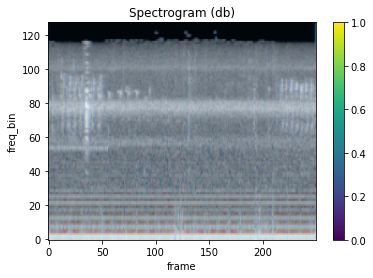

In [212]:
cmss = MixedSig2Spec(cfg)
spec = cmss(sig)
plot_spectrogram(spec)

In [202]:
spec.shape

torch.Size([3, 128, 250])

# spec augment

In [203]:
tdl = TrainDataset(cfg).loader
tdi = iter(tdl)

In [210]:
x, y = next(tdi)

In [211]:
import lark 
ms2s = lark.ops.Sig2Spec(cfg, forward_as_image=False)

In [212]:
specs = ms2s(x).cpu()

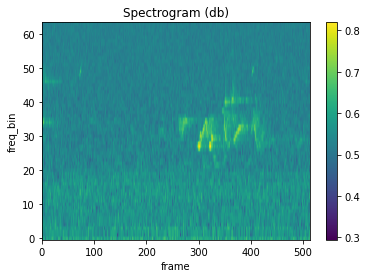

In [213]:
plot_spectrogram(specs[23])

## time masking

In [216]:
masking = tat.TimeMasking(time_mask_param=70)
tpms = masking(specs)

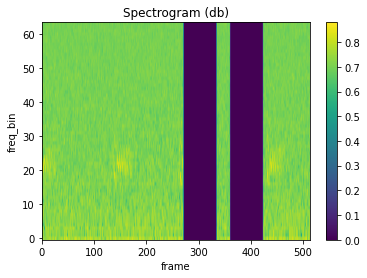

In [218]:
plot_spectrogram(tpms[22])

## time stretch

In [197]:
ms = tat.Spectrogram(
      n_fft=cfg.n_fft,
      win_length=cfg.window_length,
      hop_length=cfg.hop_length,
      center=True,
      pad_mode="reflect",
      power=None,
  )



# ms = tat.MelSpectrogram(
#             sample_rate=cfg.sr,
#             n_fft=cfg.n_fft,
#             win_length=cfg.window_length,
#             hop_length=cfg.hop_length,
#             f_min=cfg.f_min,
#             f_max=cfg.f_max,
#             pad=0,
#             n_mels=cfg.n_mels,
#             power=2.0,
#             normalized=False,
#         )

In [198]:
x.shape

torch.Size([32, 1, 160000])

In [199]:
i = 23

In [ ]:
plot_spectrogram(tx[23])

In [200]:
specs = ms(x)
spec = specs[i]
strech = tat.TimeStretch()

rate = 1.2
spec_ = strech(spec, rate)
plot_spectrogram(F.complex_norm(spec_[0]), title=f"Stretched x{rate}", aspect='equal', xmax=304)

plot_spectrogram(F.complex_norm(spec[0]), title="Original", aspect='equal', xmax=304)

rate = 0.9
spec_ = strech(spec, rate)
plot_spectrogram(F.complex_norm(spec_[0]), title=f"Stretched x{rate}", aspect='equal', xmax=304)

RuntimeError: The size of tensor a (257) must match the size of tensor b (201) at non-singleton dimension 1

# normalization

In [96]:
from lark.ops import MixedSig2Spec
from lark.data import *
from torchvision import transforms

In [174]:
cfg = Config(site='SSW')
mss = MixedSig2Spec(cfg)

In [ ]:
tdl = TrainDataset(cfg).loader
tdi = iter(tdl)
mean = torch.Tensor([0.485, 0.456, 0.406])
std = torch.Tensor([0.229, 0.224, 0.225])
tf = transforms.Normalize(mean=mean, std=std)

In [160]:
x, y = next(tdi)
i = np.random.randint(32)

In [161]:
specs = mss(x.cuda()).cpu()
# specs = tf(specs)
specs.shape

torch.Size([32, 3, 128, 250])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


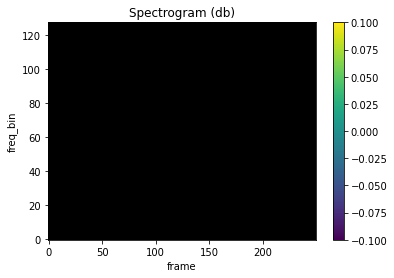

In [162]:
plot_spectrogram(specs[i])

In [163]:
tf_no_norm_specs = tf(specs)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


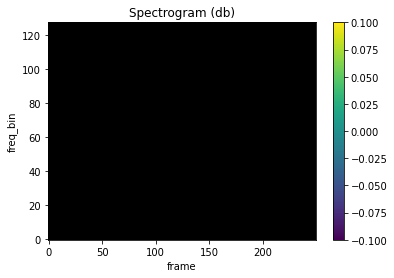

In [165]:
plot_spectrogram(tf_no_norm_specs[i])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


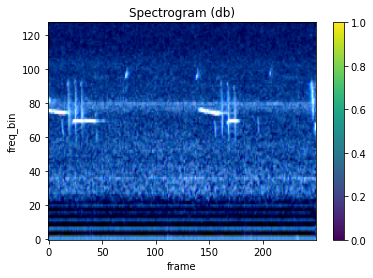

In [168]:
plot_spectrogram(tf(mss.normalize(specs))[i])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


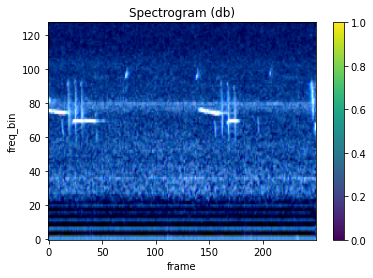

In [169]:
plot_spectrogram(tf(specs)[i])

In [171]:
(tf(mss.normalize(specs)) == tf(specs)).all()

tensor(True)

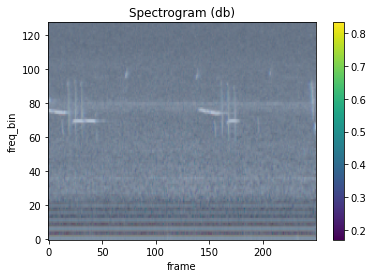

In [172]:
plot_spectrogram(mss.normalize(tf(specs))[i])

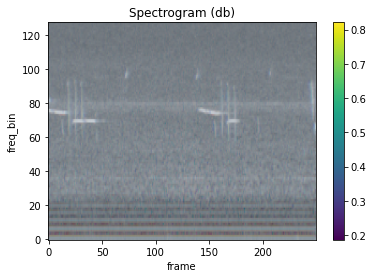

In [173]:
plot_spectrogram(mss.normalize(specs)[i])

In [175]:
specs = mss(x.cuda()).cpu()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


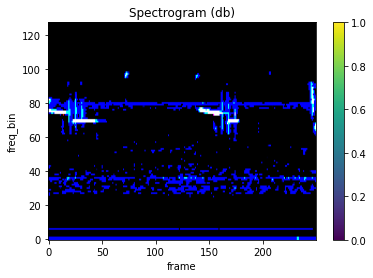

In [176]:
plot_spectrogram(specs[i])

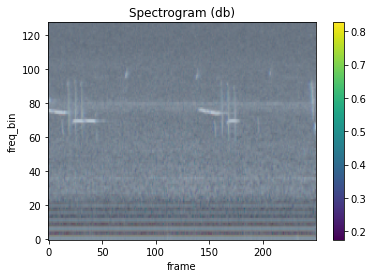

In [177]:
plot_spectrogram(mss.normalize(specs)[i])

# valid dataset vs train dataset

In [246]:
vdl = ValidDataset(cfg).loader
vdi = iter(vdl)

In [492]:
vx, vy = next(vdi)

In [493]:
vy

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
  

In [494]:
from lark.ops import MixedSig2Spec, Sig2Spec

In [495]:
ms2s = MixedSig2Spec(cfg)
s2s = Sig2Spec(cfg, forward_as_image=True)

In [499]:
vspecs = ms2s(vx.cuda())

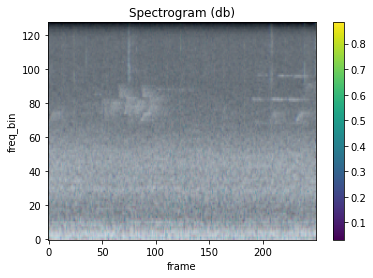

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0.])

In [510]:
i = 13
plot_spectrogram(vspecs[i].cpu())
vy[i]

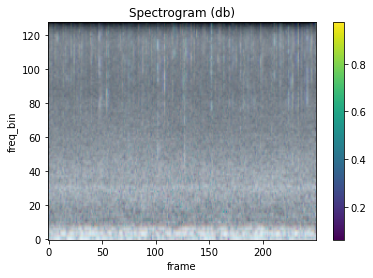

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [417]:
i = 9
plot_spectrogram(vspecs[i].cpu())
vy[i]

In [502]:
cfg.noise_nsr_dbs = [20]
tdl = TrainDataset(cfg).loader
tdi = iter(tdl)

In [511]:
tx, ty = next(tdi)
tspecs = ms2s(tx.cuda()).cpu()

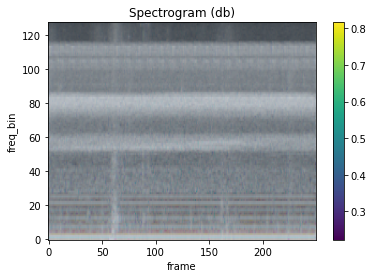

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])

In [512]:
i = 20
plot_spectrogram(tspecs[i])
ty[i]

# image size 224

In [206]:
import torchvision

In [180]:
tdl = TrainDataset(cfg).loader
tdi = iter(tdl)

In [198]:
x, y = next(tdi)

In [218]:
window_lengths = [800, 1600, 3200]
hop_lengths = [320, 800, 1600]
n_mels = 128
i = 0

ms = tat.MelSpectrogram(
            sample_rate=32000,
            n_fft=window_lengths[i],
            win_length=window_lengths[i],
            hop_length=hop_lengths[i],
            f_min=cfg.f_min,
            f_max=cfg.f_max,
            pad=0,
            n_mels=n_mels,
            power=2.0,
            normalized=False,
)

# tf_resize = torchvision.transforms.Resize((128, 250))
# tf_resize = torchvision.transforms.Resize((224, 250))
tf_resize = torchvision.transforms.Resize((224, 224))

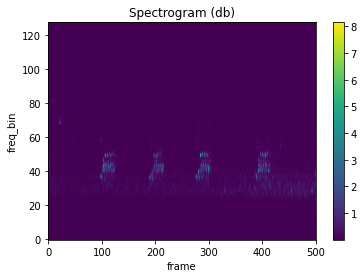

In [213]:
specs = ms(x)
j = 10
plot_spectrogram(specs[j])

In [214]:
specs[j].shape

torch.Size([1, 128, 501])

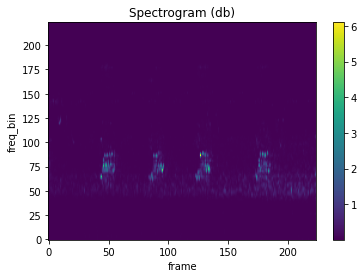

In [219]:
rszd = tf_resize(specs)
plot_spectrogram(rszd[j])

# filters

In [41]:
def show_sig(sig):
    play_audio(sig, 32000)
    plot_spectrogram(p2db(melspec(sig)))

In [42]:
sig = read_random_sig(f"data/birdclef-2021/train_short_audio.wav/paltan1/", 160000)

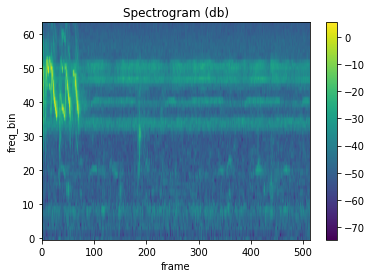

In [43]:
show_sig(sig)

In [489]:
# sinc 3k : high-pass
# sinc -4k: low-pass
# sinc 3k-4k: band-pass
# sinc 4k-3k: band-reject

def make_random_filter():
    filters = ['high-pass', 'low-pass', 'band-pass', 'band-reject']
    filter_type = filters[np.random.randint(len(filters))]
    if filter_type == 'high-pass':
        f = f"{np.random.randint(150, 2000)}"
    elif filter_type == 'low-pass':
        f = f"{- np.random.randint(6000, 12000)}"
    elif filter_type == 'band-pass':
        f = f"{np.random.randint(150, 3500)}-{np.random.randint(6000, 15000)}"
    else:  # filter_type  == 'bandstop':
        center = np.random.randint(1000, 12000)
        width = np.random.randint(500, 2000) // 2
        lo = center - width
        hi = center + width
        f = f"{hi}-{lo}"
    r = ["sinc", f]
    print(filter_type)
    print(r)
    return r

In [534]:
f = make_random_filter()

high-pass
['sinc', '1491']


In [535]:
# f = ['sinc', '-12000']

In [536]:
x_sig, _ = ta.sox_effects.apply_effects_tensor(sig, 32000, [f])

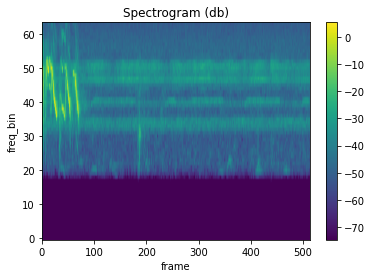

In [537]:
show_sig(x_sig)

# speed up validation data loader

In [7]:
cfg = Config(sites=['COR', 'SSW'])

In [11]:
df_ss = pd.read_csv(f"{cfg.data_dir}/train_soundscape_labels.csv")
if cfg.sites is not None:
    df_ss = df_ss[df_ss['site'].isin(cfg.sites)].reset_index(drop=True)
labels = cfg.labels
indices = {b: labels.index(b) for b in labels}
n_frames = cfg.valid_duration * cfg.sr


In [12]:
df_ss

row_id site  audio_id  seconds   birds
0        7019_COR_5  COR      7019        5  nocall
1       7019_COR_10  COR      7019       10  nocall
2       7019_COR_15  COR      7019       15  nocall
3       7019_COR_20  COR      7019       20  nocall
4       7019_COR_25  COR      7019       25  nocall
...             ...  ...       ...      ...     ...
2395  54955_SSW_580  SSW     54955      580  nocall
2396  54955_SSW_585  SSW     54955      585  grycat
2397  54955_SSW_590  SSW     54955      590  grycat
2398  54955_SSW_595  SSW     54955      595  nocall
2399  54955_SSW_600  SSW     54955      600  nocall

[2400 rows x 5 columns]

In [15]:
idx = 100

row = df_ss.iloc[idx]
fname = glob.glob(f"{cfg.data_dir}/train_soundscapes.wav/{row.audio_id}_{row.site}_*.wav")[0]

In [16]:
fname

['data/birdclef-2021/train_soundscapes.wav/7019_COR_20190904.ogg.wav']

In [17]:
df_ss['filename'] = df_ss.apply(
            lambda row: glob.glob(f"{cfg.data_dir}/train_soundscapes.wav/{row.audio_id}_{row.site}_*.wav")[0], axis=1)

In [18]:
df_ss

row_id site  audio_id  seconds   birds  \
0        7019_COR_5  COR      7019        5  nocall   
1       7019_COR_10  COR      7019       10  nocall   
2       7019_COR_15  COR      7019       15  nocall   
3       7019_COR_20  COR      7019       20  nocall   
4       7019_COR_25  COR      7019       25  nocall   
...             ...  ...       ...      ...     ...   
2395  54955_SSW_580  SSW     54955      580  nocall   
2396  54955_SSW_585  SSW     54955      585  grycat   
2397  54955_SSW_590  SSW     54955      590  grycat   
2398  54955_SSW_595  SSW     54955      595  nocall   
2399  54955_SSW_600  SSW     54955      600  nocall   

                                               filename  
0     data/birdclef-2021/train_soundscapes.wav/7019_...  
1     data/birdclef-2021/train_soundscapes.wav/7019_...  
2     data/birdclef-2021/train_soundscapes.wav/7019_...  
3     data/birdclef-2021/train_soundscapes.wav/7019_...  
4     data/birdclef-2021/train_soundscapes.wav/7019_...  
...                                                 ...  
2395  data/birdclef-2021/train_soundscapes.wav/54955...  
2396  data/birdclef-2021/train_soundscapes.wav/54955...  
2397  data/birdclef-2021/train_soundscapes.wav/54955...  
2398  data/birdclef-2021/train_soundscapes.wav/54955...  
2399  data/birdclef-2021/train_soundscapes.wav/54955...  

[2400 rows x 6 columns]

In [20]:
df_ss['offset'] = df_ss.apply(
            lambda row: cfg.sr * (row.seconds - cfg.valid_duration), axis=1)

In [21]:
df_ss

row_id site  audio_id  seconds   birds  \
0        7019_COR_5  COR      7019        5  nocall   
1       7019_COR_10  COR      7019       10  nocall   
2       7019_COR_15  COR      7019       15  nocall   
3       7019_COR_20  COR      7019       20  nocall   
4       7019_COR_25  COR      7019       25  nocall   
...             ...  ...       ...      ...     ...   
2395  54955_SSW_580  SSW     54955      580  nocall   
2396  54955_SSW_585  SSW     54955      585  grycat   
2397  54955_SSW_590  SSW     54955      590  grycat   
2398  54955_SSW_595  SSW     54955      595  nocall   
2399  54955_SSW_600  SSW     54955      600  nocall   

                                               filename    offset  
0     data/birdclef-2021/train_soundscapes.wav/7019_...         0  
1     data/birdclef-2021/train_soundscapes.wav/7019_...    160000  
2     data/birdclef-2021/train_soundscapes.wav/7019_...    320000  
3     data/birdclef-2021/train_soundscapes.wav/7019_...    480000  
4     data/birdclef-2021/train_soundscapes.wav/7019_...    640000  
...                                                 ...       ...  
2395  data/birdclef-2021/train_soundscapes.wav/54955...  18400000  
2396  data/birdclef-2021/train_soundscapes.wav/54955...  18560000  
2397  data/birdclef-2021/train_soundscapes.wav/54955...  18720000  
2398  data/birdclef-2021/train_soundscapes.wav/54955...  18880000  
2399  data/birdclef-2021/train_soundscapes.wav/54955...  19040000  

[2400 rows x 7 columns]

In [26]:
def make_label(row):
    label = np.zeros(len(labels))
    if row.birds != 'nocall':
        birds = row.birds.split(' ')
        ixs = [indices[b] for b in birds]
        label[ixs] = 1.0
    return label

In [27]:
df_ss['label'] = df_ss.apply(make_label, axis=1)

In [28]:
df_ss

row_id site  audio_id  seconds   birds  \
0        7019_COR_5  COR      7019        5  nocall   
1       7019_COR_10  COR      7019       10  nocall   
2       7019_COR_15  COR      7019       15  nocall   
3       7019_COR_20  COR      7019       20  nocall   
4       7019_COR_25  COR      7019       25  nocall   
...             ...  ...       ...      ...     ...   
2395  54955_SSW_580  SSW     54955      580  nocall   
2396  54955_SSW_585  SSW     54955      585  grycat   
2397  54955_SSW_590  SSW     54955      590  grycat   
2398  54955_SSW_595  SSW     54955      595  nocall   
2399  54955_SSW_600  SSW     54955      600  nocall   

                                               filename    offset  \
0     data/birdclef-2021/train_soundscapes.wav/7019_...         0   
1     data/birdclef-2021/train_soundscapes.wav/7019_...    160000   
2     data/birdclef-2021/train_soundscapes.wav/7019_...    320000   
3     data/birdclef-2021/train_soundscapes.wav/7019_...    480000   
4     data/birdclef-2021/train_soundscapes.wav/7019_...    640000   
...                                                 ...       ...   
2395  data/birdclef-2021/train_soundscapes.wav/54955...  18400000   
2396  data/birdclef-2021/train_soundscapes.wav/54955...  18560000   
2397  data/birdclef-2021/train_soundscapes.wav/54955...  18720000   
2398  data/birdclef-2021/train_soundscapes.wav/54955...  18880000   
2399  data/birdclef-2021/train_soundscapes.wav/54955...  19040000   

                                                  label  
0     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
1     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
3     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
4     [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
...                                                 ...  
2395  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2396  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2397  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2398  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2399  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  

[2400 rows x 8 columns]

In [45]:
torch.from_numpy(np.stack(df_ss.label.values))

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], dtype=torch.float64)

In [54]:
df_ss['sig'] = df_ss.apply(lambda row: ta.load(filepath=row.filename, frame_offset=row.offset, num_frames=n_frames)[0].numpy(), axis=1)

In [56]:
np.stack(df_ss.sig.values)

array([[[-0.08554077, -0.08383179, -0.04125977, ...,  0.01947021,
          0.0163269 , -0.00427246]],

       [[ 0.02111816,  0.00305176, -0.02267456, ...,  0.02932739,
          0.02664185,  0.01434326]],

       [[ 0.01834106,  0.04598999,  0.05685425, ..., -0.01574707,
         -0.04095459, -0.04013062]],

       ...,

       [[-0.00869751, -0.01364136, -0.02215576, ...,  0.07815552,
          0.07116699,  0.06863403]],

       [[ 0.05584717,  0.04107666,  0.02578735, ..., -0.05130005,
         -0.05111694, -0.04418945]],

       [[-0.04455566, -0.04745483, -0.04260254, ..., -0.01016235,
         -0.01791382, -0.02130127]]], dtype=float32)

In [50]:
torch.stack(torch.from_numpy(df_ss.sig.values)).shape

TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint8, and bool.

In [29]:
from lark.data import ValidDataset

In [38]:
vds = ValidDataset(cfg)

In [39]:
vds.df_ss

row_id site  audio_id  seconds   birds  \
0        7019_COR_5  COR      7019        5  nocall   
1       7019_COR_10  COR      7019       10  nocall   
2       7019_COR_15  COR      7019       15  nocall   
3       7019_COR_20  COR      7019       20  nocall   
4       7019_COR_25  COR      7019       25  nocall   
...             ...  ...       ...      ...     ...   
2395  54955_SSW_580  SSW     54955      580  nocall   
2396  54955_SSW_585  SSW     54955      585  grycat   
2397  54955_SSW_590  SSW     54955      590  grycat   
2398  54955_SSW_595  SSW     54955      595  nocall   
2399  54955_SSW_600  SSW     54955      600  nocall   

                                                  fname    offset  \
0     data/birdclef-2021/train_soundscapes.wav/7019_...         0   
1     data/birdclef-2021/train_soundscapes.wav/7019_...    160000   
2     data/birdclef-2021/train_soundscapes.wav/7019_...    320000   
3     data/birdclef-2021/train_soundscapes.wav/7019_...    480000   
4     data/birdclef-2021/train_soundscapes.wav/7019_...    640000   
...                                                 ...       ...   
2395  data/birdclef-2021/train_soundscapes.wav/54955...  18400000   
2396  data/birdclef-2021/train_soundscapes.wav/54955...  18560000   
2397  data/birdclef-2021/train_soundscapes.wav/54955...  18720000   
2398  data/birdclef-2021/train_soundscapes.wav/54955...  18880000   
2399  data/birdclef-2021/train_soundscapes.wav/54955...  19040000   

                                                  label  
0     [tensor(0.), tensor(0.), tensor(0.), tensor(0....  
1     [tensor(0.), tensor(0.), tensor(0.), tensor(0....  
2     [tensor(0.), tensor(0.), tensor(0.), tensor(0....  
3     [tensor(0.), tensor(0.), tensor(0.), tensor(0....  
4     [tensor(0.), tensor(0.), tensor(0.), tensor(0....  
...                                                 ...  
2395  [tensor(0.), tensor(0.), tensor(0.), tensor(0....  
2396  [tensor(0.), tensor(0.), tensor(0.), tensor(0....  
2397  [tensor(0.), tensor(0.), tensor(0.), tensor(0....  
2398  [tensor(0.), tensor(0.), tensor(0.), tensor(0....  
2399  [tensor(0.), tensor(0.), tensor(0.), tensor(0....  

[2400 rows x 8 columns]

In [40]:
vds[3]

(tensor([[-0.1019, -0.1306, -0.1141,  ...,  0.0782,  0.0799,  0.0706]]),
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

# __fin__ValidDataset